In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# import data 
deliveries = pd.read_csv("deliveries.csv")
matches = pd.read_csv("matches.csv")


In [3]:
#kxip vs rr

## 1. Who will win the match KXIP or RR?

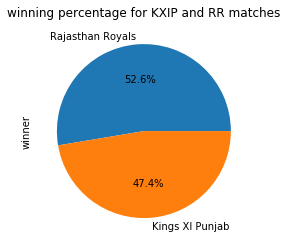

In [7]:
#get matches between KXIP and RR
kxip_rr_matches = matches[((matches.team1=='Kings XI Punjab')&(matches.team2=='Rajasthan Royals'))|((matches.team2=='Kings XI Punjab')&(matches.team1=='Rajasthan Royals'))]

#getting wins count
kxip_rr_matches.winner.value_counts().plot(kind='pie', autopct='%1.1f%%', title="winning percentage for KXIP and RR matches")

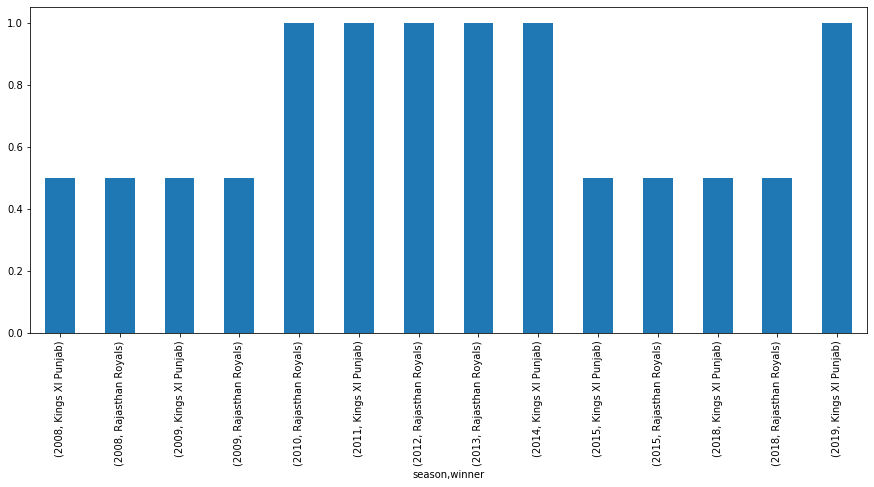

In [13]:
#getting matches between KXIP nad RR matchwise
kxip_rr_matches.groupby('season')['winner'].value_counts(normalize=True).plot(kind='bar', figsize=(15,6))

In [32]:
def get_season_winpercent(team_name):
    """
    takes team name as input and returns season wise winning percent
    """

    #count matches played by KXIP
    get_matches = matches[(matches.team1==team_name)|(matches.team2==team_name)]

    #getting matches played by team per season
    matches_played = get_matches.groupby('season')['id'].count().reset_index()
    matches_played = matches_played.rename(columns={'id': 'tot_matches_played' })

    #getting matches won by team per season
    matches_won = matches[matches.winner==team_name].groupby('season')['id'].count().reset_index()
    matches_won = matches_won.rename(columns={'id': 'tot_matches_won' })

    matches_wins = matches_played.merge(matches_won, on='season')
    matches_wins['winning_percent'] = matches_wins.tot_matches_won/matches_wins.tot_matches_played*100
    return matches_wins[['season', 'winning_percent']]

In [82]:
#get winning percent of KXIP per season
kxip_winp = get_season_winpercent('Kings XI Punjab')

#get winning percent of RR per season
rr_winp = get_season_winpercent('Rajasthan Royals')


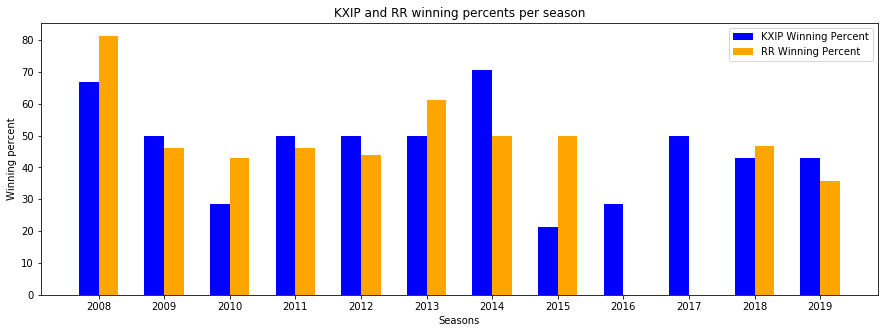

In [90]:
#checking visually
width=0.30
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(kxip_winp.season-width/2, kxip_winp.winning_percent, width , color='b', label='KXIP Winning Percent')
ax.bar(rr_winp.season+width/2, rr_winp.winning_percent, width,  color='orange', label='RR Winning Percent')
plt.xlabel("Seasons")
plt.ylabel("Winning percent")
plt.title("KXIP and RR winning percents per season")
plt.xticks(np.arange(2008,2020))
plt.legend()
plt.show()

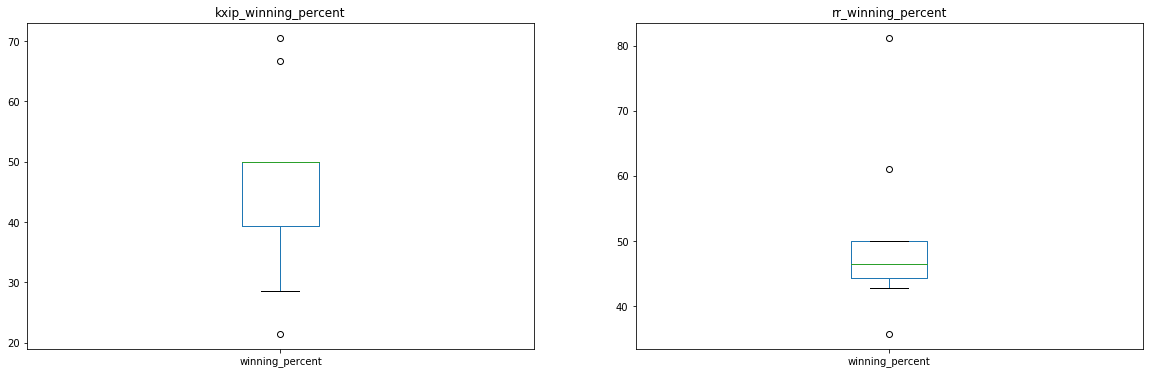

In [87]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
kxip_winp.winning_percent.plot('box', ax=ax[0], title='kxip_winning_percent')
rr_winp.winning_percent.plot('box', ax=ax[1], title='rr_winning_percent')

**Inference:**
    We can see KXIP seem to have higher winninger percent per season than RR and also on average winning percent is higher overall for KXIP.

2. Which batsman will have the highest (# of runs scored through boundaries) to (total runs scored) ration in the match? 

Consider only those players who play more than 10 balls. If 2 players end up with the same ratio then the batsman with a higher strike rate will be chosen. If this also remains same for 2 batsman, then the one who scores more 6s off the bowler with a lesser economy rate will be selected as the answer. Even if this turns out to be the same, then other metrics and tie breakers will be considered and the answer decided by Widhya will be "FINAL". 

In [95]:
#get all matches between kxip and rr
kxip_rr_all = deliveries[((deliveries.bowling_team=='Kings XI Punjab')&(deliveries.batting_team=='Rajasthan Royals'))|((deliveries.bowling_team=='Rajasthan Royals')&(deliveries.batting_team=='Kings XI Punjab'))]

In [210]:
def matchwise_batsman_totalruns(df):

    #get total runs scored by batsman per match
    match_batsman_runs = df.groupby(['match_id', 'batsman'])['batsman_runs'].sum().reset_index()
    
    return match_batsman_runs

def matchwise_batsman_boundaries(df):
    
    #filter rows where only boundaries were scored
    df_boundaries = df[df.batsman_runs.isin([4,6])]

    #get total boundaries scored by batsman per match
    match_batsman_boundaries = df_boundaries.groupby(['match_id', 'batsman'])['batsman_runs'].agg(['sum','count']).reset_index()
    match_batsman_boundaries = match_batsman_boundaries.rename(columns={'sum':'total_boundary_runs', 'count':'boundary_count'})
    
    return match_batsman_boundaries

def matchwise_batsman_scored123(df):
    
    #filter rows where only boundaries were scored
    df_boundaries = df[df.batsman_runs.isin([1,2,3])]

    #get total boundaries scored by batsman per match
    match_batsman_boundaries = df_boundaries.groupby(['match_id', 'batsman'])['batsman_runs'].agg(['sum','count']).reset_index()
    match_batsman_boundaries = match_batsman_boundaries.rename(columns={'sum':'total_scored123_runs', 'count':'scored123_count'})
    
    return match_batsman_boundaries

def matchwise_batsman_ballsplayed(df):
    
    match_batsman_balls = df.groupby(['match_id', 'batsman'])['ball'].count().reset_index()
    
    return match_batsman_balls

def matchwise_batsman_strikerate(df):
    
    df_strike_rate = matchwise_batsman_totalruns(df).merge(matchwise_batsman_ballsplayed(df), on =['match_id','batsman'])
    df_strike_rate['strike_rate'] = np.round(df_strike_rate['batsman_runs']/df_strike_rate['ball']*100,3)
    return df_strike_rate[['match_id', 'batsman', 'strike_rate']]    



    

def matchwise_bowler_totovers(df):    
    
    match_bowler_totovers = df.groupby(['match_id', 'bowler'])['over'].nunique().reset_index()
    
    return match_bowler_totovers

def matchwise_bowler_gaveruns(df):
    
    match_bowler_gaveruns = df.groupby(['match_id', 'bowler'])['total_runs'].sum().reset_index()
    
    return match_bowler_gaveruns
    
    
def economy_rate(df):

    match_bowler_economyrate =  matchwise_bowler_gaveruns(df).merge(matchwise_bowler_totovers(df), on=['match_id', 'bowler'])
    
    return match_bowler_economyrate


# def scored6_

In [236]:
# df = kxip_rr_all.copy()

#get batsman who player more than 10 balls atleast
batsman_atleast_10ball = matchwise_batsman_ballsplayed(kxip_rr_all)[matchwise_batsman_ballsplayed(kxip_rr_all).ball>10]

# get ratio : (# of runs scored through boundaries) to (total runs scored) ration in the match
result = matchwise_batsman_boundaries(kxip_rr_all).merge(matchwise_batsman_totalruns(kxip_rr_all), on=['match_id', 'batsman'], suffixes=['_boundaries', '_total']).merge(batsman_atleast_10ball, on=['match_id', 'batsman'])

# get required ratio
result['ratio'] = result['total_boundary_runs']/result['batsman_runs']

#adding strike rate to result df
result = result.merge(matchwise_batsman_strikerate(kxip_rr_all), on=['match_id', 'batsman'])

# get person who scored highest per match

s_samson_count = []
kl_rahul_counts = []
c_gayle_count = []
s_smith = []
r_uthappa = []
j_butler = []
others = []
counts = {}



d = result.groupby('batsman').median().sort_values(['ratio','strike_rate'])

d

# result

,match_id,total_boundary_runs,boundary_count,batsman_runs,ball,ratio,strike_rate
batsman,,,,,,,
BA Stokes,7933.0,4.0,1.0,15.0,11.0,0.266667,136.3640
N Pooran,11140.0,4.0,1.0,14.0,15.0,0.285714,93.3330
CA Pujara,464.0,12.0,3.0,40.0,38.0,0.300000,105.2630
AR Patel,520.0,8.0,2.0,24.0,29.0,0.333333,82.7590
RA Tripathi,9627.0,10.0,2.5,31.5,29.5,0.335664,98.8290
SK Warne,130.0,12.0,3.0,34.0,35.0,0.352941,97.1430
Gurkeerat Singh,376.0,6.0,1.5,16.5,20.0,0.373913,79.3335
R Tewatia,509.0,6.0,1.0,16.0,13.0,0.375000,123.0770
AL Menaria,305.0,15.0,3.0,34.0,27.0,0.441176,126.0990


In [196]:
for id in result.match_id.unique():
    df1 = result[result.match_id==id].sort_values(by=['ratio', 'strike_rate'], ascending=False)
    display(df1)
#     if df1.batsman.

,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
3,65,K Goel,24,5,26,21,0.923077,123.810
7,65,Yuvraj Singh,42,9,57,35,0.736842,162.857
5,65,RA Jadeja,26,6,36,27,0.722222,133.333
0,65,DS Lehmann,12,3,17,17,0.705882,100.000
4,65,PP Chawla,16,4,24,11,0.666667,218.182
6,65,SR Watson,50,10,76,51,0.657895,149.020
2,65,JR Hopes,8,2,16,16,0.500000,100.000
1,65,IK Pathan,6,1,12,19,0.500000,63.158


,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
14,97,Yuvraj Singh,44,8,49,16,0.897959,306.250
13,97,YK Pathan,30,6,39,15,0.769231,260.000
11,97,SE Marsh,86,18,115,72,0.747826,159.722
10,97,Niraj Patel,40,10,57,40,0.701754,142.500
8,97,JR Hopes,34,8,51,35,0.666667,145.714
9,97,M Rawat,14,3,23,19,0.608696,121.053
12,97,SR Watson,10,2,22,19,0.454545,115.789


,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
20,130,YK Pathan,8,2,10,13,0.800000,76.923
18,130,RS Bopara,8,2,11,16,0.727273,68.750
16,130,KC Sangakkara,34,8,60,53,0.566667,113.208
15,130,IK Pathan,20,4,39,34,0.512821,114.706
19,130,SK Warne,12,3,34,35,0.352941,97.143
17,130,RA Jadeja,8,2,37,44,0.216216,84.091


,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
27,145,SM Katich,8,2,10,13,0.800000,76.923
26,145,RA Jadeja,26,6,33,12,0.787879,275.000
25,145,NV Ojha,50,10,68,51,0.735294,133.333
24,145,KC Sangakkara,8,2,11,15,0.727273,73.333
22,145,GC Smith,54,13,77,44,0.701299,175.000
21,145,DPMD Jayawardene,6,1,9,11,0.666667,81.818
28,145,Yuvraj Singh,30,6,48,44,0.625000,109.091
23,145,IK Pathan,8,2,19,18,0.421053,105.556


,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
32,193,KC Sangakkara,24,6,29,14,0.827586,207.143
34,193,MS Bisla,28,6,35,19,0.800000,184.211
33,193,MJ Lumb,28,7,41,30,0.682927,136.667
29,193,AC Voges,26,6,45,24,0.577778,187.500
31,193,FY Fazal,26,6,45,40,0.577778,112.500
37,193,Yuvraj Singh,6,1,15,14,0.400000,107.143
36,193,YK Pathan,10,2,28,22,0.357143,127.273
30,193,DPMD Jayawardene,6,1,23,22,0.260870,104.545
35,193,RS Bopara,4,1,25,26,0.160000,96.154


,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
40,212,MJ Lumb,76,18,83,45,0.915663,184.444
41,212,MS Bisla,16,4,20,15,0.800000,133.333
44,212,Yuvraj Singh,22,4,28,16,0.785714,175.000
38,212,DPMD Jayawardene,30,7,44,35,0.681818,125.714
43,212,YK Pathan,12,2,21,14,0.571429,150.000
42,212,NV Ojha,22,5,44,38,0.500000,115.789
39,212,IK Pathan,4,1,24,23,0.166667,104.348


,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
45,256,AC Gilchrist,22,5,28,17,0.785714,164.706
49,256,PC Valthaty,34,7,46,32,0.739130,143.750
51,256,SR Watson,16,4,24,16,0.666667,150.000
50,256,SE Marsh,42,9,71,43,0.591549,165.116
48,256,KD Karthik,12,3,21,17,0.571429,123.529
47,256,AS Raut,12,3,25,21,0.480000,119.048
52,256,STR Binny,14,3,30,24,0.466667,125.000
46,256,AL Menaria,14,3,34,26,0.411765,130.769


,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
54,311,AM Rahane,70,17,98,72,0.714286,136.111
53,311,AC Gilchrist,18,4,27,19,0.666667,142.105
58,311,PC Valthaty,8,2,13,15,0.615385,86.667
57,311,Mandeep Singh,20,5,34,25,0.588235,136.000
55,311,BJ Hodge,10,2,21,16,0.476190,131.250
56,311,Bipul Sharma,8,2,18,13,0.444444,138.462
59,311,R Dravid,12,3,28,24,0.428571,116.667


,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
66,354,SR Watson,28,6,36,18,0.777778,200.000
65,354,SE Marsh,26,6,34,29,0.764706,117.241
64,354,R Dravid,32,8,46,39,0.695652,117.949
61,354,Azhar Mahmood,14,3,24,25,0.583333,96.000
62,354,BJ Hodge,20,4,36,23,0.555556,156.522
60,354,AL Menaria,16,3,34,28,0.470588,121.429
63,354,Gurkeerat Singh,8,2,23,25,0.347826,92.000


,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
72,398,R Dravid,8,2,9,12,0.888889,75.000
74,398,SR Watson,28,7,32,21,0.875000,152.381
73,398,R Sathish,8,2,11,12,0.727273,91.667
70,398,DJ Hussey,22,5,41,31,0.536585,132.258
69,398,BJ Hodge,8,2,15,16,0.533333,93.750
68,398,Azhar Mahmood,12,3,23,20,0.521739,115.000
75,398,SV Samson,12,3,27,23,0.444444,117.391
71,398,Gurkeerat Singh,4,1,10,15,0.400000,66.667
67,398,AM Rahane,12,3,34,43,0.352941,79.070


,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
79,436,SR Watson,18,4,31,25,0.580645,124.000
76,436,AC Gilchrist,24,6,42,32,0.571429,131.250
80,436,SV Samson,26,6,47,33,0.553191,142.424
77,436,AM Rahane,30,6,59,52,0.508475,113.462
78,436,SE Marsh,36,8,77,66,0.467532,116.667


,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
84,464,GJ Maxwell,68,14,89,47,0.764045,189.362
86,464,SR Watson,38,8,50,30,0.760000,166.667
85,464,SPD Smith,20,5,27,15,0.740741,180.000
83,464,DA Miller,36,6,51,20,0.705882,255.000
87,464,SV Samson,36,7,52,34,0.692308,152.941
81,464,AM Nayar,14,3,23,21,0.608696,109.524
82,464,CA Pujara,12,3,40,38,0.300000,105.263


,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
92,509,JP Faulkner,28,5,35,13,0.800000,269.231
93,509,M Vohra,18,4,25,21,0.720000,119.048
95,509,SE Marsh,26,6,40,36,0.650000,111.111
89,509,BJ Hodge,20,4,31,19,0.645161,163.158
97,509,WP Saha,16,4,27,20,0.592593,135.000
96,509,SV Samson,14,3,30,29,0.466667,103.448
90,509,DA Miller,12,2,29,20,0.413793,145.000
91,509,GJ Bailey,10,2,26,18,0.384615,144.444
94,509,R Tewatia,6,1,16,13,0.375000,123.077
88,509,AM Rahane,8,2,23,27,0.347826,85.185


,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
99,520,DA Miller,18,4,23,22,0.782609,104.545
103,520,KK Nair,6,1,8,11,0.750000,72.727
100,520,DJ Hooda,22,4,30,15,0.733333,200.000
106,520,STR Binny,8,2,13,19,0.615385,68.421
105,520,SPD Smith,20,5,33,24,0.606061,137.500
104,520,M Vijay,22,5,37,35,0.594595,105.714
101,520,GJ Bailey,14,3,24,20,0.583333,120.000
102,520,JP Faulkner,26,5,46,37,0.565217,124.324
98,520,AR Patel,8,2,24,29,0.333333,82.759


,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
112,536,SR Watson,32,7,45,39,0.711111,115.385
111,536,SE Marsh,50,11,77,45,0.649351,171.111
108,536,DA Miller,34,6,54,31,0.629630,174.194
110,536,M Vijay,12,2,21,18,0.571429,116.667
109,536,KK Nair,14,3,25,14,0.560000,178.571
107,536,AM Rahane,36,8,74,54,0.486486,137.037


,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
113,7931,CH Gayle,8,2,8,11,1.000000,72.727
115,7931,KK Nair,20,4,31,23,0.645161,134.783
117,7931,MP Stoinis,14,3,24,17,0.583333,141.176
114,7931,JC Buttler,32,8,57,39,0.561404,146.154
116,7931,KL Rahul,46,10,86,56,0.534884,153.571
119,7931,S Gopal,12,3,24,16,0.500000,150.000
120,7931,SV Samson,14,3,29,23,0.482759,126.087
118,7931,RA Tripathi,4,1,11,13,0.363636,84.615


,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
124,7933,KL Rahul,60,14,101,70,0.594059,144.286
123,7933,JC Buttler,42,10,83,59,0.506024,140.678
121,7933,AD Nath,4,1,9,13,0.444444,69.231
125,7933,SV Samson,10,2,23,18,0.434783,127.778
122,7933,BA Stokes,4,1,15,11,0.266667,136.364


,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
128,11140,JC Buttler,52,12,69,43,0.753623,160.465
129,11140,MA Agarwal,16,3,23,25,0.695652,92.000
127,11140,CH Gayle,60,13,91,52,0.659341,175.000
131,11140,SN Khan,30,7,47,30,0.638298,156.667
126,11140,AM Rahane,16,4,27,20,0.592593,135.000
132,11140,SPD Smith,10,2,24,17,0.416667,141.176
130,11140,N Pooran,4,1,14,15,0.285714,93.333
133,11140,SV Samson,6,1,30,25,0.200000,120.000


,match_id,batsman,sum,count,batsman_runs,ball,ratio,strike_rate
135,11323,CH Gayle,30,6,34,22,0.882353,154.545
141,11323,STR Binny,26,5,33,11,0.787879,300.000
139,11323,MA Agarwal,16,3,26,12,0.615385,216.667
137,11323,JC Buttler,16,3,29,20,0.551724,145.000
136,11323,DA Miller,24,5,45,28,0.533333,160.714
138,11323,KL Rahul,24,5,53,47,0.452830,112.766
140,11323,RA Tripathi,16,4,52,46,0.307692,113.043
142,11323,SV Samson,8,2,28,22,0.285714,127.273
134,11323,AM Rahane,4,1,26,21,0.153846,123.810


**Inference:**
    If we check the scores as per the conditions and check in how many matches each players listed the highest and also calculate the mean of the scores we can see SV Samson and KL Rahul have been a consistent player however, CH Gayle and Buttler have performed exceptionally well in few of the matches. We can probably go with Sanju Smason or KL Rahul as our option. 

3. Consider a new metric called "Overall Player Performance that can be considered for batsmen and bowlers. The formula for OPP for every batsman is given as - [(# of runs scored by the player/# of balls faced by the player) + (# of runs scored off boundaries) - (+ of runs scored off 1s, 2s and 3s)/(Total balls faced by the player)). Once you compute the OPP for every batsman, you're supposed to normalise it using the formula : [(OPP of batsman - min(OPP among all batsmen))/(max(OPP among all batsmen)-min(OPP among all batsmen)). For a bowler, the OPP formula is given as - (# of boundary runs given/# of boundaries hit off the bowler in the match)/(total balls bowled by the bowler in the match)]. Just like how you normalised the OPPs for batsman, you're also supposed to normalise the OPP for bowlers. Note, the normalised OPP values for both, batsmen and bowlers, will lie between O and 1. If a player bats and bowls, you will have to consider both the formulae individually and sum them up to find the OPP for a player. This way, the max OPP for any player in a match would be 2. Which player do you thin will end up with the highest OPP in the match?

    * Chris Gayle or Jofra Archer
    * Rahul Tewatia or KL Rahul 
    * Ben Stokes or Mohammed Shami
    * Others

In [234]:
def overall_performance_batsman(df):

    df1 = matchwise_batsman_totalruns(df).merge(matchwise_batsman_ballsplayed(df), on=['match_id', 'batsman'])

    df2 = matchwise_batsman_scored123(df).merge(matchwise_batsman_ballsplayed(df), on=['match_id', 'batsman'])

    df3 = matchwise_batsman_boundaries(df).merge(matchwise_batsman_ballsplayed(df), on=['match_id', 'batsman'])

    result = df1.merge(df2, on=['match_id', 'batsman', 'ball']).merge(df3, on=['match_id', 'batsman', 'ball'])

    result['opp_batsman'] = (df4['batsman_runs']/df4['ball']) + (df4['total_boundary_runs']) - (df4['total_scored123_runs']/df4['ball'])

    from sklearn.preprocessing import MinMaxScaler #works as per normalizing given

    min_max = MinMaxScaler()

    result['opp_batsman_normalized'] = min_max.fit_transform(result['opp_batsman'].values.reshape(-1,1))

    return result[['match_id', 'batsman', 'opp_batsman_normalized']]

In [ ]:
def matchwise_bowler_gaveruns(df):
    
    match_bowler_gaveruns = df.groupby(['match_id', 'bowler'])['total_runs'].sum().reset_index()
    
    return match_bowler_gaveruns

def matchwise_bowler_ballsbowled(df):
    
    match_bowler_ballsbowled = df.groupby(['match_id', 'bowler'])['ball'].count().reset_index()
    match_bowler_ballsbowled = match_bowler_gaveruns.rename(columns={'ball':'balls_bowled'})
    
    return match_bowler_ballsbowled

def matchwise_bowler_boundaries(df):
    
    

4. How many dot balls will be bowled in the entire match?

    * Less than 60
    * 60-90
    * 91-120 
    * 121 or more

In [114]:
def get_dot_balls(df):
    """
    take data frame for total team matches and returns dot balls bowled by each bowler per match
    """

    #counting number of dot balls i,e where no wicket is taken neither runs are taken

    #total balls bowled by the bowler
    df_tot_balls = df.groupby(['match_id', 'bowler'])['total_runs'].count().reset_index()
    df_tot_balls = df_tot_balls.rename(columns={'total_runs': 'total_balls'})

    #total dots bowled by the bowler
    df_dots = df[(df.total_runs==0)|(df.player_dismissed==np.nan)]
    df_tot_dots = df_dots.groupby(['match_id', 'bowler'])['total_runs'].count().reset_index()
    df_tot_dots = df_tot_dots.rename(columns={'total_runs': 'total_dots'})

    df_dots_all = df_tot_balls.merge(df_tot_dots, how='left', on=['match_id', 'bowler'])
    
    return df_dots_all

In [109]:
# get dot balls bowled in KXIP and RR matches
kxip_rr_dots = get_dot_balls(kxip_rr_all)

# counting total dots per match
kxip_rr_dots_count = kxip_rr_dots.groupby('match_id')['total_dots'].sum()

# checking the stats
kxip_rr_dots_count.describe()

count     19.000000
mean      84.736842
std       12.861839
min       69.000000
25%       75.000000
50%       81.000000
75%       97.000000
max      108.000000
Name: total_dots, dtype: float64

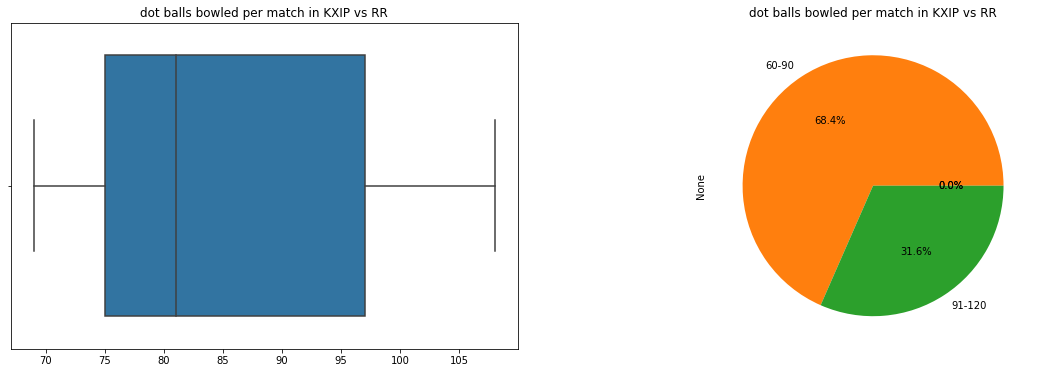

In [110]:
# checking plots

#checking as per options visually
fig, ax= plt.subplots(1,2, figsize=(20,6))

ax[0].set_title('dot balls bowled per match in KXIP vs RR')
sns.boxplot(kxip_rr_dots_count.values, ax=ax[0])

pd.cut(kxip_rr_dots_count.values, bins=[0,60, 91, 121, 200], labels=['Less than 60', '60-90', '91-120', '121 or more or both teams wont score 75 runs']).value_counts().plot("pie", autopct='%1.1f%%', title='dot balls bowled per match in KXIP vs RR', ax=ax[1]);

**Inference:**
    If we calculate dot balls bowled per match by both teams and check statistics we get 84 as an average and for probability for options 60-90 will be the safest option has highest probability to have dot balls in this range.

5. How many balls will Mohammed Shami take, to get his first wicket?

    * 0-6
    * 7-12
    * 13-18
    * 19-24

In [92]:
def ball_first_wicket(df, bowler_name):
    """Takes bowlers name and both teams dataframe and returns ball at which player took his first wicket for every match if no wicket returns 0"""
    
    bowler_all = df[df.bowler==bowler_name]
    
    first_wickets = []
    
    for m in bowler_all.match_id.unique():
        df1 = bowler_all[bowler_all.match_id==m]
        wickets=np.argwhere(df1['player_dismissed'].notnull())
        if len(wickets)>0:
            first_wickets.append(wickets[0][0])
        else:
            first_wickets.append(np.nan)
        
    result=pd.DataFrame({'match_id' : bowler_all.match_id.unique().tolist(),
                        'first_wickets' : first_wickets})
    return result
    

In [111]:
#count first wickets for Mohammed Shami
first_wicket_counts = ball_first_wicket(kxip_rr_all, 'Mohammed Shami')
first_wicket_counts.first_wickets.describe()

count     2.000000
mean     17.000000
std       7.071068
min      12.000000
25%      14.500000
50%      17.000000
75%      19.500000
max      22.000000
Name: first_wickets, dtype: float64

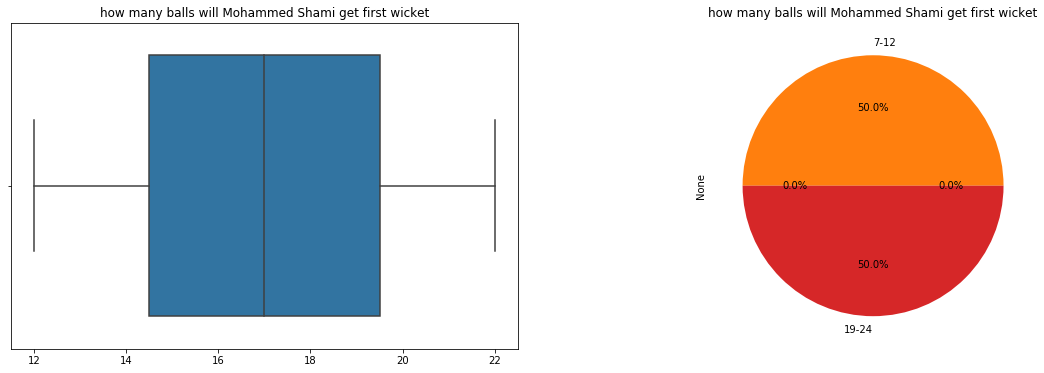

In [113]:
# checking plots

#checking as per options visually
fig, ax= plt.subplots(1,2, figsize=(20,6))

ax[0].set_title('how many balls will Mohammed Shami get first wicket')
sns.boxplot(first_wicket_counts.first_wickets.values, ax=ax[0])

pd.cut(first_wicket_counts.first_wickets.values, bins=[0,7, 13, 19, 25], labels=['0-6', '7-12', '13-18', '19-24']).value_counts().plot("pie", autopct='%1.1f%%', title='how many balls will Mohammed Shami get first wicket', ax=ax[1]);

In [197]:
**Inference:**
    If we check Shamis performance on overage he 

SyntaxError: invalid syntax (<ipython-input-197-f8c1b3c49c1e>, line 1)

In [ ]:
If